In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/SNT_dataset.csv"
df = pd.read_csv(file_path)


In [ ]:
# Handle Non-Numeric Columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
label_encoders = {col: LabelEncoder() for col in non_numeric_cols}
for col in non_numeric_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

In [ ]:
# Remove rows where the target column ('label') has NaN
df = df.dropna(subset=['label'])

In [ ]:
# Separate Features and Target
target_column = 'label'
X = df.drop(columns=[target_column])
y = df[target_column].astype(int)

In [ ]:
# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Convert to numpy arrays for cross-validation
X = np.array(X_scaled)
y = np.array(y)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Define Model with BatchNorm, Dropout, and L2 Regularization
class FedModel(nn.Module):
    def __init__(self, input_size):
        super(FedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Introduce Small Label Noise (1% Flipped Labels)
def add_label_noise(y, noise_ratio=0.01):
    n_samples = int(len(y) * noise_ratio)
    flip_indices = np.random.choice(len(y), n_samples, replace=False)
    y_noisy = y.copy()
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

In [ ]:
# Evaluate Model
def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predictions.numpy())

    return y_true, y_pred

In [ ]:
# Federated Training Function
def train_federated(global_model, client_loaders, epochs=5, weight_decay=5e-4):
    criterion = nn.CrossEntropyLoss()
    client_models = [FedModel(input_size=X.shape[1]) for _ in range(len(client_loaders))]
    optimizers = [optim.Adam(model.parameters(), lr=0.0005, weight_decay=weight_decay) for model in client_models]

    for epoch in range(epochs):
        for i in range(len(client_loaders)):
            client_models[i].load_state_dict(global_model.state_dict())
            client_models[i].train()
            epoch_loss = 0
            for X_batch, y_batch in client_loaders[i]:
                optimizers[i].zero_grad()
                outputs = client_models[i](X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizers[i].step()
                epoch_loss += loss.item()

        # Federated Averaging
        global_model.load_state_dict(
            {key: sum(model.state_dict()[key] for model in client_models) / len(client_models) for key in global_model.state_dict()}
        )

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
# Cross-validation Federated Training with Data Noise
def train_federated_cv(global_model, X_train, y_train, num_clients=5, epochs=5, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    final_X_val_fold = None
    final_y_val_fold = None
    final_global_model = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"Training Fold {fold + 1}/{num_folds}")

        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Apply Label Noise
        y_train_fold = add_label_noise(y_train_fold)

        # Save the last fold's validation data
        if fold == num_folds - 1:
            final_X_val_fold, final_y_val_fold = X_val_fold, y_val_fold

        # Split among clients
        X_train_split = np.array_split(X_train_fold, num_clients)
        y_train_split = np.array_split(y_train_fold, num_clients)

        client_datasets = []
        for i in range(num_clients):
            X_tensor = torch.tensor(X_train_split[i], dtype=torch.float32)
            y_tensor = torch.tensor(y_train_split[i], dtype=torch.long)
            dataset = TensorDataset(X_tensor, y_tensor)
            client_datasets.append(DataLoader(dataset, batch_size=64, shuffle=True))

        # Train federated model
        global_model_copy = FedModel(input_size=X_train.shape[1])
        train_federated(global_model_copy, client_datasets, epochs=epochs, weight_decay=5e-4)

        # Evaluate
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        y_true, y_pred = evaluate_model(global_model_copy, val_loader)
        fold_accuracy = accuracy_score(y_val_fold, y_pred)
        fold_results.append(fold_accuracy)

        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")

    final_acc = np.mean(fold_results)
    print(f"Cross-validation Mean Accuracy: {final_acc:.4f}, Std: {np.std(fold_results):.4f}")

    return final_acc, final_X_val_fold, final_y_val_fold, global_model_copy

In [ ]:
# Train with Cross-validation and Get Final Validation Data
final_accuracy, X_val_fold, y_val_fold, global_model = train_federated_cv(
    global_model, X, y, num_clients=5, epochs=5, num_folds=5
)

# Convert validation data to tensors
X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)

# Get Model Predictions and Scores
global_model.eval()
with torch.no_grad():
    y_scores = torch.softmax(global_model(X_val_tensor), dim=1)[:, 1].numpy()  # Probability of class 1
    y_pred = np.round(y_scores)  # Convert probabilities to 0 or 1

Training Fold 1/5
Epoch 1/5, Loss: 189.7362
Epoch 2/5, Loss: 162.0737
Epoch 3/5, Loss: 159.6877
Epoch 4/5, Loss: 161.3552
Epoch 5/5, Loss: 161.2433
Fold 1 Accuracy: 0.9507
Training Fold 2/5
Epoch 1/5, Loss: 193.9083
Epoch 2/5, Loss: 165.0243
Epoch 3/5, Loss: 163.4579
Epoch 4/5, Loss: 163.9918
Epoch 5/5, Loss: 164.4633
Fold 2 Accuracy: 0.8163
Training Fold 3/5
Epoch 2/5, Loss: 163.8499
Epoch 3/5, Loss: 161.6657
Epoch 4/5, Loss: 161.3906
Epoch 5/5, Loss: 160.8207
Fold 3 Accuracy: 0.9210
Training Fold 4/5
Epoch 1/5, Loss: 206.5460
Epoch 2/5, Loss: 164.2778
Epoch 3/5, Loss: 163.0590
Epoch 4/5, Loss: 161.6859
Epoch 5/5, Loss: 162.8919
Fold 4 Accuracy: 1.0000
Training Fold 5/5
Epoch 1/5, Loss: 282.4249
Epoch 2/5, Loss: 175.0630
Epoch 3/5, Loss: 169.4741
Epoch 4/5, Loss: 166.3578
Epoch 5/5, Loss: 165.4560
Fold 5 Accuracy: 0.9980
Cross-validation Mean Accuracy: 0.9372, Std: 0.0674

Confusion Matrix:
 [[105097    418]
 [     2 101416]]


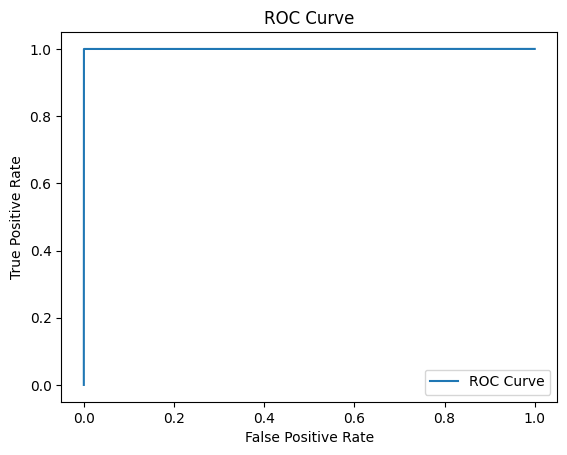

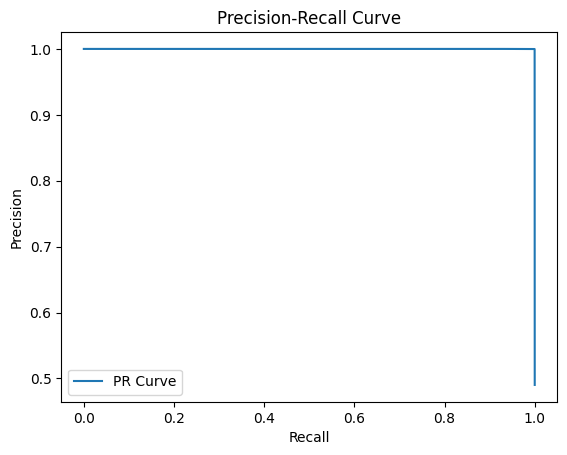

In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)

# Plot ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Plot PR Curve
def plot_pr_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

# Display Results
plot_confusion_matrix(y_val_fold, y_pred)
plot_roc_curve(y_val_fold, y_scores)
plot_pr_curve(y_val_fold, y_scores)
